In [1]:
import os
import sys
sys.path.append(os.path.abspath(".."))
sys.path.append(os.path.abspath("../hifigan"))
from hifigan.inference_mel import get_mel, load_wav, MAX_WAV_VALUE
import hifigan.inference_mel as mel_module
import scipy.signal as sps
import json
import torch

## Load Wave

In [2]:
filename = "../nsynth-valid/audio/guitar_acoustic_010-086-100.wav"
filename = "../nsynth-valid/audio/mallet_acoustic_056-065-050.wav"
filename = "../nsynth-valid/audio/reed_acoustic_023-042-127.wav"
filename = "../nsynth-valid/audio/flute_acoustic_002-093-075.wav"
wav, sr = load_wav(filename)
number_of_samples = round(len(wav) * float(22050) / sr)
wav = sps.resample(wav, number_of_samples)
wav = wav / MAX_WAV_VALUE
wav = torch.FloatTensor(wav)

## Encodec Model Sanity Check

In [3]:
from encodec import EncodecModel
model = EncodecModel.encodec_model_24khz(pretrained=True).encoder
wav.shape

/home/jli3268/miniconda3/envs/marble/lib/python3.8/site-packages/torch/nn/utils/weight_norm.py:134: FutureWarning: `torch.nn.utils.weight_norm` is deprecated in favor of `torch.nn.utils.parametrizations.weight_norm`.
  WeightNorm.apply(module, name, dim)


torch.Size([88200])

In [4]:
wav_encodec, sr = load_wav(filename)
number_of_samples = round(len(wav_encodec) * float(24000) / sr)
wav_encodec = sps.resample(wav_encodec, number_of_samples)
wav_encodec = torch.FloatTensor(wav_encodec)
wav_encodec = wav_encodec.unsqueeze(0).unsqueeze(0)
wav_encodec.shape
with torch.no_grad():
    encoded_frames = model(wav_encodec)
print(encoded_frames.shape)

torch.Size([1, 128, 300])


In [5]:
decoder = EncodecModel.encodec_model_24khz(pretrained=True).decoder
output = decoder(encoded_frames)
print(output.shape)

torch.Size([1, 1, 96000])


In [6]:
import IPython.display as ipd
ipd.display(ipd.Audio(output.detach().squeeze(), rate=24000))

## Extract Mel Spec

In [7]:
class AttrDict(dict):
    def __init__(self, *args, **kwargs):
        super(AttrDict, self).__init__(*args, **kwargs)
        self.__dict__ = self

config_file = "../hifigan/checkpoint/config.json"
with open(config_file) as f:
    data = f.read()

global h
json_config = json.loads(data)
h = AttrDict(json_config)
print(h)

{'resblock': '1', 'num_gpus': 0, 'batch_size': 16, 'learning_rate': 0.0002, 'adam_b1': 0.8, 'adam_b2': 0.99, 'lr_decay': 0.999, 'seed': 1234, 'upsample_rates': [8, 8, 2, 2], 'upsample_kernel_sizes': [16, 16, 4, 4], 'upsample_initial_channel': 512, 'resblock_kernel_sizes': [3, 7, 11], 'resblock_dilation_sizes': [[1, 3, 5], [1, 3, 5], [1, 3, 5]], 'resblock_initial_channel': 256, 'segment_size': 8192, 'num_mels': 80, 'num_freq': 1025, 'n_fft': 1024, 'hop_size': 256, 'win_size': 1024, 'sampling_rate': 22050, 'fmin': 0, 'fmax': 8000, 'fmax_loss': None, 'num_workers': 4, 'dist_config': {'dist_backend': 'nccl', 'dist_url': 'tcp://localhost:54321', 'world_size': 1}}


In [8]:
mel_module.h = h
x = get_mel(wav.unsqueeze(0))
x.shape

/home/jli3268/miniconda3/envs/marble/lib/python3.8/site-packages/torch/functional.py:666: UserWarning: stft with return_complex=False is deprecated. In a future pytorch release, stft will return complex tensors for all inputs, and return_complex=False will raise an error.
Note: you can still call torch.view_as_real on the complex output to recover the old return format. (Triggered internally at /opt/conda/conda-bld/pytorch_1724789116784/work/aten/src/ATen/native/SpectralOps.cpp:873.)
  return _VF.stft(input, n_fft, hop_length, win_length, window,  # type: ignore[attr-defined]


torch.Size([1, 80, 344])

## Plot Original Audio Mel-spectrogram

<Figure size 640x480 with 0 Axes>

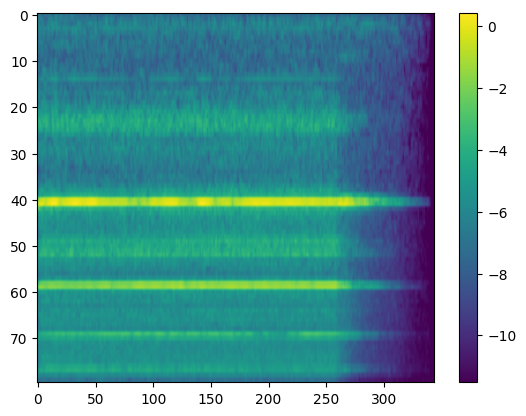

In [9]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np

mel_spectrogram = x[0]
mel_spectrogram_np = mel_spectrogram.detach().cpu().numpy()

plt.clf()
# 使用 Matplotlib 将梅尔频谱图转换为彩色图像
fig, ax = plt.subplots()
cax = ax.imshow(mel_spectrogram_np, aspect='auto', cmap='viridis')  # 选择一个彩色 colormap，比如 viridis
fig.colorbar(cax)

plt.show()

# 将 Matplotlib 图像保存到内存中
fig.canvas.draw()
img = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)
img = img.reshape(fig.canvas.get_width_height()[::-1] + (3,))


## Load hifi-gan

In [10]:
from hifigan.models import Generator
def load_checkpoint(filepath, device):
    assert os.path.isfile(filepath)
    print("Loading '{}'".format(filepath))
    checkpoint_dict = torch.load(filepath, map_location=device)
    print("Complete.")
    return checkpoint_dict

In [11]:
device = torch.device('cpu')

generator = Generator(h).to(device)

checkpoint_file = "../hifigan/checkpoint/generator_v1"
state_dict_g = load_checkpoint(checkpoint_file, device)
generator.load_state_dict(state_dict_g['generator'])

generator.eval()
generator.remove_weight_norm()

Loading '../hifigan/checkpoint/generator_v1'
Complete.
Removing weight norm...


/home/jli3268/miniconda3/envs/marble/lib/python3.8/site-packages/torch/nn/utils/weight_norm.py:134: FutureWarning: `torch.nn.utils.weight_norm` is deprecated in favor of `torch.nn.utils.parametrizations.weight_norm`.
  WeightNorm.apply(module, name, dim)
/tmp/ipykernel_2009470/381390241.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_o

## Hifi-GAN Inference

In [12]:
with torch.no_grad():
    y_g_hat = generator(x)
    audio = y_g_hat.squeeze()
    audio = audio * MAX_WAV_VALUE
    audio = audio.cpu().numpy().astype('int16')

In [13]:
audio.shape

(88064,)

In [14]:
import IPython.display as ipd
ipd.display(ipd.Audio(audio, rate=22050))

## Compare with original

In [15]:
wav, sr = load_wav(filename)
number_of_samples = round(len(wav) * float(22050) / sr)
wav = sps.resample(wav, number_of_samples)
wav = wav / MAX_WAV_VALUE
ipd.display(ipd.Audio(wav, rate=22050))

## Load Reconstruct Model

In [16]:
from models import ReconstructModel

/home/jli3268/miniconda3/envs/marble/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [17]:
# checkpoint_path = "/home/jli3268/ReconWav/work_dir_encodec/weight_v2/epoch=28-val_loss-total=1.342.ckpt"
checkpoint_path = "/home/jli3268/ReconWav/work_dir_encodec/weight_v5/epoch=18-val_loss-total=1.173.ckpt"
checkpoint_path = "/home/jli3268/ReconWav/work_dir_encodec/weight_v6/epoch=29-val_loss-total=0.917.ckpt"
model = ReconstructModel.load_from_checkpoint(checkpoint_path)

/home/jli3268/miniconda3/envs/marble/lib/python3.8/site-packages/lightning_fabric/utilities/cloud_io.py:48: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(f

## Model Inference

In [18]:
wav, sr = load_wav(filename)
number_of_samples = round(len(wav) * float(24000) / sr) # resample to encodec sample rate (24000)
wav = sps.resample(wav, number_of_samples)
wav = wav / MAX_WAV_VALUE
wav_batch = torch.from_numpy(wav).float().unsqueeze(0).unsqueeze(0)
# model.inference_step(wav)

In [19]:
mel_output = model.inference_step(wav_batch)

## Plot result Mel Spectrogram

<Figure size 640x480 with 0 Axes>

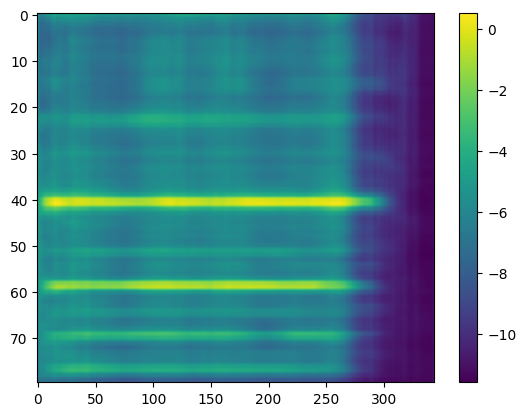

In [20]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np

mel_spectrogram = mel_output[0]
mel_spectrogram_np = mel_spectrogram.detach().cpu().numpy()

plt.clf()
# 使用 Matplotlib 将梅尔频谱图转换为彩色图像
fig, ax = plt.subplots()
cax = ax.imshow(mel_spectrogram_np, aspect='auto', cmap='viridis')  # 选择一个彩色 colormap，比如 viridis
fig.colorbar(cax)

# 将 Matplotlib 图像保存到内存中
fig.canvas.draw()
img = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)
img = img.reshape(fig.canvas.get_width_height()[::-1] + (3,))

In [21]:
with torch.no_grad():
    y_g_hat = generator(mel_output)
    audio = y_g_hat.squeeze()
    audio = audio * MAX_WAV_VALUE
    audio = audio.cpu().numpy().astype('int16')

In [22]:
import IPython.display as ipd
ipd.display(ipd.Audio(audio, rate=22050))